# NLP Disaster Tweets Text Classification with RNN

Nowadays, social media becomes an important channel to release information and announce emergencies with increasing use of mobile devices, especially Twitter. In addition to the favorite of Government departments and varieties of companies, normal users are enabled to announce emergencies observed and experienced in the real time. However, accurately tagging user messages still faces challenges in developing sufficient natural language processing model. This study focused on discovering the performance of recurrent neural network (RNN) on the text classification problem. A total of 7613 tweets that may or may not convey messages of the presence of disaster are fed to RNN for model training and hyperparameter tuning. Training data has 5 columns in total - id, keyword, location, text, target - where id and target are integers, and the other three features are strings. The other 3263 tweets are test data and it has the same structure as training data except missing target labels. Test data will be leveraged for performance evaluation of the optimized RNN.

### Citation

Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

## Exploratory Data Analysis

Resources provided by Google Colab are utilized for training recurrent neural network. Tweets data and other required information are copied to the Colab environment for faster access. Beyond importing library and building environment, several summary statistis charts and plots are created to investigate tweets data and discover hidden pattern. Enhanced understanding through the approach of EDA will be beneficial for deciding model architecture and training models.

In [1]:
# import library
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, RNN, LSTM, GRU, Dropout, Dense
from google.colab import drive

In [2]:
# Extract data from the zip file and move to the local env.
drive.mount('/gdrive', force_remount = True)
data_path = '/gdrive/MyDrive/week4_project/nlp-getting-started.zip'
local_path = '/content'
!cp '{data_path}' .
os.chdir(local_path)
!unzip -q 'nlp-getting-started.zip' -d '/content/data/'

Mounted at /gdrive


In [3]:
# load training and test data
tweets_train = pd.read_csv(os.path.join(local_path, 'data', 'train.csv'))
tweets_test = pd.read_csv(os.path.join(local_path, 'data', 'test.csv'))

In [4]:
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweets_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
tweets_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
tweets_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


Training data has 7613 records in total, and it contains five columns - id, keyword, location, text and target. Id and target are numeric while the other three features are strings. Keyword and location are the only two columns that contain null values. Both are decided to be dropped since they will not be used in this project. Similar operations are processed on testing data as well.

In [8]:
tweets_train_c = tweets_train.drop(['keyword', 'location'], axis = 1)
tweets_train_c.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
tweets_test_c = tweets_test.drop(['keyword', 'location'], axis = 1)
tweets_test_c.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# check duplicates
tweets_train_c = tweets_train_c.drop(['id'], axis = 1)
tweets_train_c[tweets_train_c.duplicated()]

,text,target
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,Experts in France begin examining airplane deb...,1
630,To fight bioterrorism sir.,1
...,...,...
7600,Evacuation order lifted for town of Roosevelt:...,1
7607,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [11]:
tweets_train_c.drop_duplicates(inplace = True)
tweets_train_c[tweets_train_c.duplicated()]

,text,target


In [12]:
tweets_full = tweets_train_c.assign(dataset_ind = np.repeat('train', tweets_train_c.shape[0])).append(tweets_test_c.assign(dataset_ind = np.repeat('test', tweets_test_c.shape[0])), ignore_index = True).drop(['id', 'target'], axis = 1)
print(tweets_full[tweets_full.duplicated(keep = False)].to_string())

                                                                                                                                                text dataset_ind
606                                                                                                                       To fight bioterrorism sir.       train
620                                                                                                                       To fight bioterrorism sir.       train
1190                                                            Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...       train
1207                                                              I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????       train
1214                   like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit       train
1323                              

Both training and test set have null values dropped. In addition, training set has 92 duplicated records and duplicates have been dropped since they don't add any value to the future models. Besides, training and test set don't share tweets in common. That means the model built in later steps won't suffered from data leakage.

Text(0, 0.5, 'Number of Tweets')

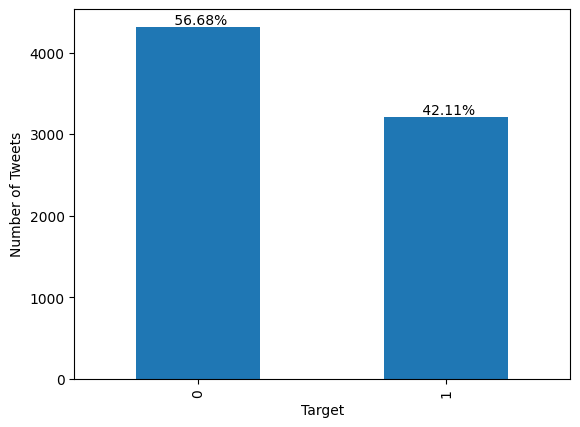

In [13]:
# check class distribution
ax = tweets_train_c['target'].value_counts().plot(kind = 'bar')
total_tweets = tweets_train['id'].count()
ax.bar_label(ax.containers[0], fmt = lambda x: f'{(x / total_tweets) * 100 : 0.2f}%')
ax.margins(x = 0.3)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Tweets')

Target class has two labels: 1 represents the tweet that describes a real disaster, and 0 otherwise. Approximately 56.68% of total tweets belongs to class 0 and the other 42.11% belongs to class 1. Target class is slightly imbalanced and it's not a concern.

In [14]:
print('max #words (train):', tweets_train_c['text'].str.split(expand = True).shape[1], '\n'
      'max #words (test):', tweets_test_c['text'].str.split(expand = True).shape[1], '\n')

max #words (train): 31 
max #words (test): 31 



In [15]:
word_freq_train = pd.DataFrame(tweets_train_c['text'].str.split(expand = True).stack().value_counts().reset_index())
word_freq_train = word_freq_train.rename(columns = {'index': 'words', 0: 'freq'})
word_freq_train.sort_values(by = 'freq', ascending = False).head(n = 10)

,words,freq
0,the,2542
1,a,1816
2,to,1788
3,in,1728
4,of,1685
5,and,1285
6,I,1192
7,for,804
8,is,801
9,on,760


In [16]:
word_freq_test = pd.DataFrame(tweets_test_c['text'].str.split(expand = True).stack().value_counts().reset_index())
word_freq_test = word_freq_test.rename(columns = {'index': 'words', 0: 'freq'})
word_freq_test.sort_values(by = 'freq', ascending = False).head(n = 10)

,words,freq
0,the,1045
1,to,808
2,a,767
3,of,750
4,in,739
5,and,547
6,I,475
7,is,373
8,on,336
9,for,311


Both training and test set shares the same maximum length of tweets (31) and top 10 most common words. It's a good sign which indicates they follow similar distributions. Additionally, all of the top 10 words appeared to be English stop words which have little semantic meanings. However, it's unnecessary to remove stop words for training word vectors using word embedding such as GloVe since they still contribute to the contextual meaning of a sentence.

<Axes: >

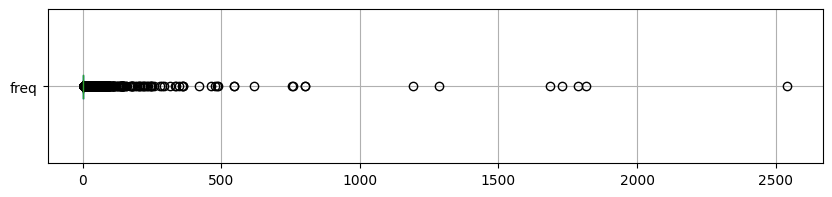

In [17]:
word_freq_train.boxplot(column = 'freq', vert = False, figsize = (10, 2))

In [18]:
print('% words appeared more than twice:', round(word_freq_train[word_freq_train['freq'] > 2].shape[0] / word_freq_train.shape[0] * 100, 2))

% words appeared more than twice: 16.5


Most words are written less than 500 times and approximately 16.5% of them appeared more than twice. In the next step, the current training set will be further split into training set and validation set. The new training set will be fed to neural network for model training while the validation set will be leveraged for model evaluation and hyperparameter tuning.

In [19]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(tweets_train_c['text'], tweets_train_c['target'], test_size = 0.2)

In [20]:
print(X_train.shape, X_val.shape)

(6016,) (1505,)


## Word Embedding

Before fitting the model, the representation of words is required to be transformed into the form of real value numeric vectors such that words that have similar meanings are closer to each other in the vector space. This technique is called word embedding and it's generally lumped into the field of natural language processing. In this study, tweets are tokenized, and each word is represented by a real value vector generated from a word embedding method named Global Vector for Word Representation (GloVe). GloVe was developed by Stanford NLP group, and it has great performance on word analogy tasks and named entity recognition problems. The algorithm leverages the ratio of co-occurrence probabilities to encode the form of meaning. The co-occurrence matrix is a squared matrix where total number of rows and columns are the same as number of words in the global corpus. The value in each cell represents the frequency of the corresponding words when they occur simultaneously. Conditional probabilities ($P(word_i|word_j)$) are then calculated based on the count of co-occurrence and the ratio of conditional probabilities are computed as a measure of relevance between different words. For example, a large probability ratio ($\frac{P(j|i)}{P(k|i)}$) will be achieved if word i ($w_i$) is more relevant to word j ($w_j$) than word k ($w_k$), and vice versa. Word vectors learned from GloVe algorithm are computed in a way such that their dot product equals the logarithm of their co-occurrence probability. Considering training word embedding is very time-consuming and resources intensive, pre-trained GloVe word embeddings will be leveraged in this study.

It's necessary for sentences to be tokenized and cleaned prior to the implementation of word embeddings. General text cleansing steps include case conversion, special characters removal as well as vectorization. Keras Tokenizer class will be utilized to achieve all of them. Maximum number of words (based on frequency) is set to 5000 to cover most of the words in our corpus based on frequency and it's a relatively small number which helps to reduce the memory cost as well.

In [21]:
# tokenize
token = Tokenizer(num_words = 5000, oov_token = 'oov')
token.fit_on_texts(X_train)

def word_processing(data, max_len):
    data_seq = token.texts_to_sequences(data)
    data_seq_padded = pad_sequences(data_seq, maxlen = max_len, padding = 'pre', truncating = 'pre')
    print('Before padding example1:', data_seq[0], '\n'
          'Before padding example2:', data_seq[1], '\n'
          'After padding example1:', data_seq_padded[0], '\n'
          'After padding example2:', data_seq_padded[1])
    return data_seq_padded

In [22]:
# padding sequences
max_len = 100
X_train_seq_padded = word_processing(X_train, max_len = max_len)
X_val_seq_padded = word_processing(X_val, max_len = max_len)

Before padding example1: [955, 1781, 1365, 7, 955, 36, 956, 1074, 607, 8, 608, 1255, 1474, 607, 21, 910, 119, 1153, 10, 4, 2, 3, 1] 
Before padding example2: [1, 446] 
After padding example1: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  955 1781 1365    7  955   36  956
 1074  607    8  608 1255 1474  607   21  910  119 1153   10    4    2
    3    1] 
After padding example2: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   

Notice that sequences generated by Tokenizer class have different length. It's crucial to pad sequences to the same length since RNN (LSTM, etc.) requires the input to have the uniform size. The maximum length is set to 100 such that sequence that has length over 100 will be truncated and sequence that's shorter will be padded by 0. Pre-padding is more favored over post-padding since RNN designed for text classification usually takes the final hidden state for prediction.

In [23]:
# pre-trained word embeddings - GloVe
glove_path = '/gdrive/MyDrive/week4_project/glove.6B.zip'
!cp '{glove_path}' .
!unzip -q 'glove.6B.zip' -d '/content/glove/'

In [24]:
path_to_glove_file = os.path.join(local_path, 'glove', 'glove.6B.100d.txt')
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coeffs = line.split(' ', maxsplit = 1)
        coeffs = np.fromstring(coeffs, dtype = 'float32', sep = ' ')
        embeddings_index[word] = coeffs

word_index = token.word_index
embeddings_matrix = np.zeros((len(word_index) + 1, max_len))
for word, ind in word_index.items():
    embedding_vec = embeddings_index.get(word)
    if embedding_vec is not None:
        embeddings_matrix[ind] = embedding_vec

Word vectors of pre-trained GloVe model has been loaded to Colab environment. Furthermore, an embedding matrix is created based on the pre-trained word vectors and the mappings in word-index dictionary. Each row in the embedding matrix represents the pre-trained word vector of the corresponding word in word-index dictionary.

## Recurrent Neural Network

According to the exploratory data analysis, the initial RNN model is designed as following:

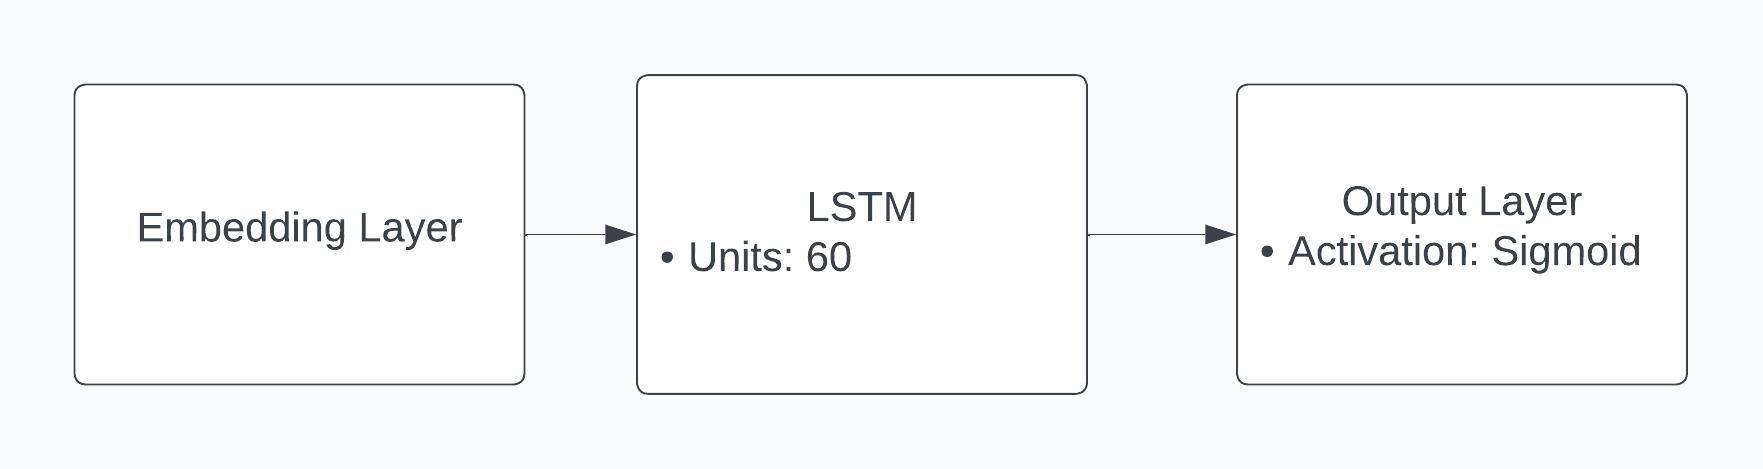

The first layer of our RNN model is an embedding layer, which is designed to map word indices to their embedding vectors. Trainable parameter is set to False since a pre-trained word embeddings are used. The embeddings are then fed to a LSTM (long short-term memory) layer with 60 LSTM units. The advantage of LSTM includes but not limited to its ability to handle vanishing and exploding gradients. The output layer uses Sigmoid function as the activation function since the architecture is designed for binary classification. Adam optimizer is applied for optimizing the neural network with an adaptive learning rate and faster convergence.


In [25]:
# RNN
model_base = Sequential()
model_base.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model_base.add(LSTM(60))
model_base.add(Dense(1, activation = 'sigmoid'))
model_base.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1945400   
                                                                 
 lstm (LSTM)                 (None, 60)                38640     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 1984101 (7.57 MB)
Trainable params: 38701 (151.18 KB)
Non-trainable params: 1945400 (7.42 MB)
_________________________________________________________________


In [29]:
hist_base = model_base.fit(X_train_seq_padded, y_train, epochs = 10, validation_data = (X_val_seq_padded, y_val))

Epoch 1/10
188/188 [==============================] - 1s 7ms/step - loss: 0.3081 - accuracy: 0.8732 - val_loss: 0.4703 - val_accuracy: 0.7973
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2927 - accuracy: 0.8785 - val_loss: 0.4777 - val_accuracy: 0.7801
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2698 - accuracy: 0.8908 - val_loss: 0.4963 - val_accuracy: 0.7973
Epoch 4/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2512 - accuracy: 0.8976 - val_loss: 0.5266 - val_accuracy: 0.8073
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.2273 - accuracy: 0.9097 - val_loss: 0.5185 - val_accuracy: 0.7973
Epoch 6/10
188/188 [==============================] - 1s 7ms/step - loss: 0.2139 - accuracy: 0.9119 - val_loss: 0.5909 - val_accuracy: 0.7907
Epoch 7/10
188/188 [==============================] - 1s 7ms/step - loss: 0.1982 - accuracy: 0.9219 - val_loss: 0.5869 - val_accuracy: 0.7787
Epoch 

In [27]:
# Performance plot function
def perform_plot(epochs, his):
    f, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].plot(range(1, epochs + 1), his['loss'], label = 'Training loss')
    ax[0].plot(range(1, epochs + 1), his['val_loss'], label = 'Validation loss')
    ax[0].legend()
    ax[0].set_title('Loss')
    ax[1].plot(range(1, epochs + 1), his['accuracy'], label = 'Training accuracy')
    ax[1].plot(range(1, epochs + 1), his['val_accuracy'], label = 'Validation accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')

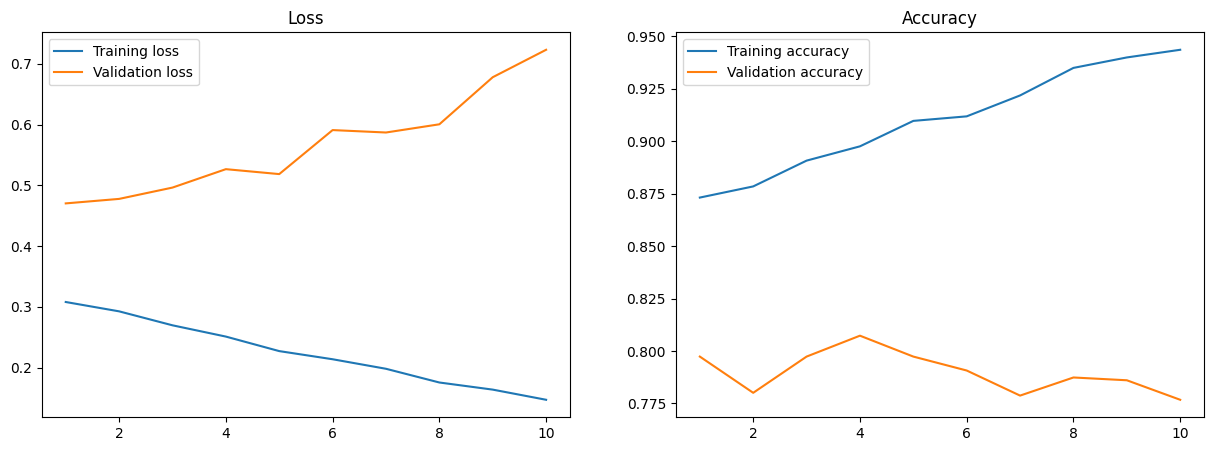

In [30]:
# Analyze model performance
perform_plot(10, hist_base.history)

Validation loss keep increasing during the training process and it diverges from the training loss starting at the first epoch. This phenomenon could be a sign of overfitting and a dropout layer that filters out 20% input units will be inserted between LSTM and output layer to handle it.

In [31]:
# Model 2 - Add dropout layer
model2 = Sequential()
model2.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model2.add(LSTM(60))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1945400   
                                                                 
 lstm_1 (LSTM)               (None, 60)                38640     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 1984101 (7.57 MB)
Trainable params: 38701 (151.18 KB)
Non-trainable params: 1945400 (7.42 MB)
_________________________________________________________________


In [32]:
hist2 = model2.fit(X_train_seq_padded, y_train, epochs = 10, validation_data = (X_val_seq_padded, y_val))

Epoch 1/10
188/188 [==============================] - 4s 9ms/step - loss: 0.5227 - accuracy: 0.7457 - val_loss: 0.4317 - val_accuracy: 0.8146
Epoch 2/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4521 - accuracy: 0.7940 - val_loss: 0.4465 - val_accuracy: 0.8000
Epoch 3/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4291 - accuracy: 0.8120 - val_loss: 0.4227 - val_accuracy: 0.8126
Epoch 4/10
188/188 [==============================] - 1s 7ms/step - loss: 0.4119 - accuracy: 0.8190 - val_loss: 0.4211 - val_accuracy: 0.8126
Epoch 5/10
188/188 [==============================] - 1s 6ms/step - loss: 0.4073 - accuracy: 0.8253 - val_loss: 0.4161 - val_accuracy: 0.8233
Epoch 6/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3918 - accuracy: 0.8281 - val_loss: 0.4234 - val_accuracy: 0.8193
Epoch 7/10
188/188 [==============================] - 1s 6ms/step - loss: 0.3827 - accuracy: 0.8359 - val_loss: 0.4228 - val_accuracy: 0.8186
Epoch 

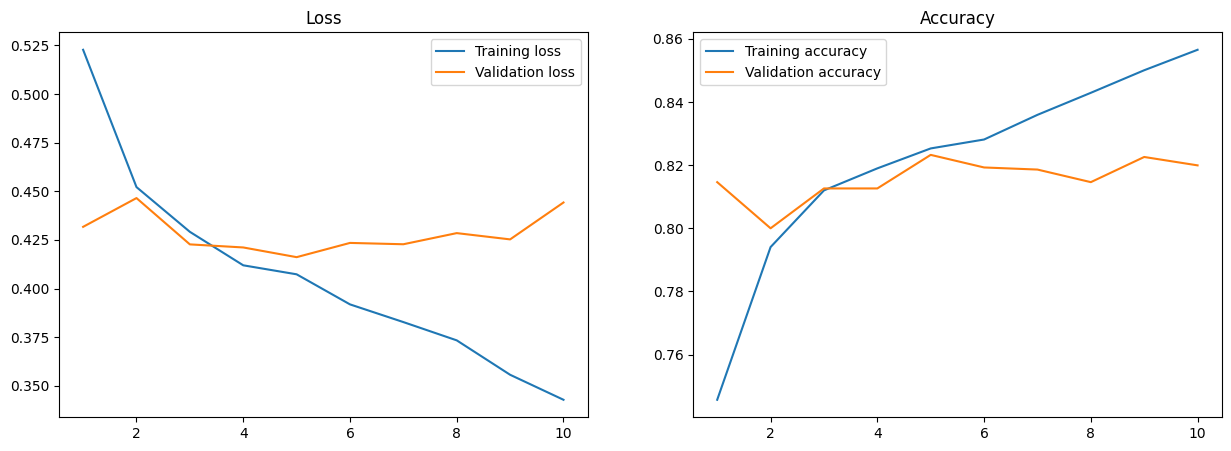

In [33]:
perform_plot(10, hist2.history)

Validation loss of the new model fluctuates around 0.43. It provides some evidence that the insertion of dropout layer handles overfitting and improves the model performance. Theoretically, a deeper neural network performs better as long as the depth is reasonable; otherwise, overfitting problem will arise. Next, two new LSTM and dropout layers will be added to achieve a better performance score.

In [34]:
# Model 3 - Add more layers
model3 = Sequential()
model3.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model3.add(LSTM(60, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(LSTM(60, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(LSTM(60))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1945400   
                                                                 
 lstm_2 (LSTM)               (None, 100, 60)           38640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 60)           29040     
                                                                 
 dropout_2 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_4 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_3 (Dropout)         (None, 60)               

In [35]:
hist3 = model3.fit(X_train_seq_padded, y_train, epochs = 10, validation_data = (X_val_seq_padded, y_val))

Epoch 1/10
188/188 [==============================] - 8s 20ms/step - loss: 0.5102 - accuracy: 0.7630 - val_loss: 0.4370 - val_accuracy: 0.8066
Epoch 2/10
188/188 [==============================] - 3s 14ms/step - loss: 0.4536 - accuracy: 0.7999 - val_loss: 0.4298 - val_accuracy: 0.8173
Epoch 3/10
188/188 [==============================] - 3s 14ms/step - loss: 0.4334 - accuracy: 0.8122 - val_loss: 0.4221 - val_accuracy: 0.8126
Epoch 4/10
188/188 [==============================] - 2s 13ms/step - loss: 0.4261 - accuracy: 0.8173 - val_loss: 0.4377 - val_accuracy: 0.8093
Epoch 5/10
188/188 [==============================] - 3s 14ms/step - loss: 0.4088 - accuracy: 0.8226 - val_loss: 0.4138 - val_accuracy: 0.8179
Epoch 6/10
188/188 [==============================] - 3s 15ms/step - loss: 0.3890 - accuracy: 0.8339 - val_loss: 0.4376 - val_accuracy: 0.8113
Epoch 7/10
188/188 [==============================] - 3s 13ms/step - loss: 0.3777 - accuracy: 0.8408 - val_loss: 0.4195 - val_accuracy: 0.8073

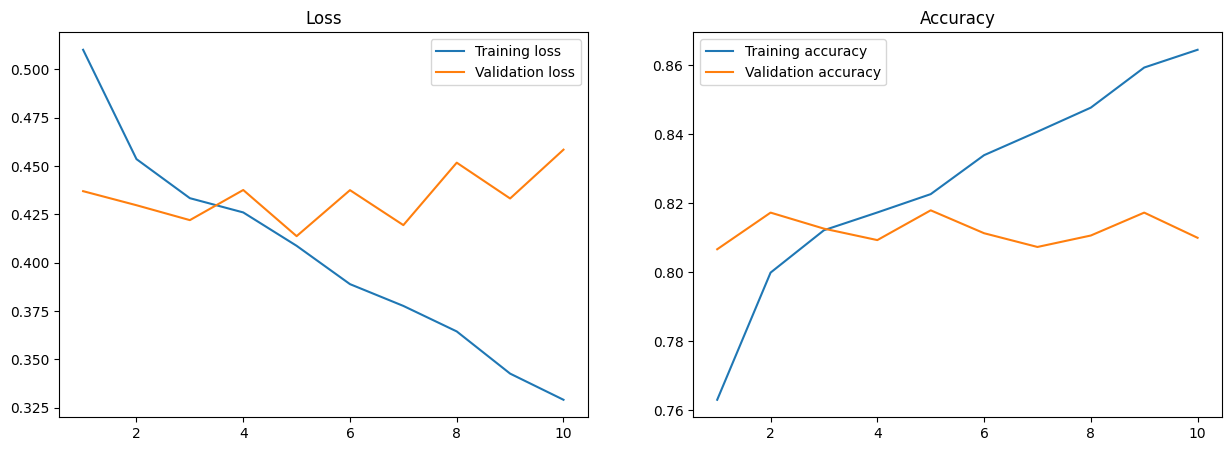

In [36]:
perform_plot(10, hist3.history)

The performance of new model is comparable to the one with one set of LSTM and dropout layer with regard to loss and accuracy score. The validation loss still fluctuates around 0.43. A reasonable suspicion is that the learning rate is too high such that the model either passes or reaches the optimum at the first epoch. This model is adapted with learning rate decreased to 0.00001. Epochs is also increased to 30 to gain a clearer picture of the training process.

In [37]:
# Model 4 - decrease learning rate
model4= Sequential()
model4.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model4.add(LSTM(60, return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(60, return_sequences = True))
model4.add(Dropout(0.2))
model4.add(LSTM(60))
model4.add(Dropout(0.2))
model4.add(Dense(1, activation = 'sigmoid'))

adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model4.compile(optimizer = adam_opt, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [38]:
hist4 = model4.fit(X_train_seq_padded, y_train, epochs = 30, validation_data = (X_val_seq_padded, y_val))

Epoch 1/30
188/188 [==============================] - 8s 20ms/step - loss: 0.6885 - accuracy: 0.5600 - val_loss: 0.6820 - val_accuracy: 0.5781
Epoch 2/30
188/188 [==============================] - 3s 13ms/step - loss: 0.6782 - accuracy: 0.5836 - val_loss: 0.6712 - val_accuracy: 0.6013
Epoch 3/30
188/188 [==============================] - 3s 13ms/step - loss: 0.6661 - accuracy: 0.6135 - val_loss: 0.6560 - val_accuracy: 0.6571
Epoch 4/30
188/188 [==============================] - 3s 14ms/step - loss: 0.6462 - accuracy: 0.6742 - val_loss: 0.6318 - val_accuracy: 0.6990
Epoch 5/30
188/188 [==============================] - 3s 14ms/step - loss: 0.6177 - accuracy: 0.7148 - val_loss: 0.5979 - val_accuracy: 0.7269
Epoch 6/30
188/188 [==============================] - 2s 13ms/step - loss: 0.5841 - accuracy: 0.7299 - val_loss: 0.5663 - val_accuracy: 0.7422
Epoch 7/30
188/188 [==============================] - 2s 13ms/step - loss: 0.5573 - accuracy: 0.7463 - val_loss: 0.5444 - val_accuracy: 0.7515

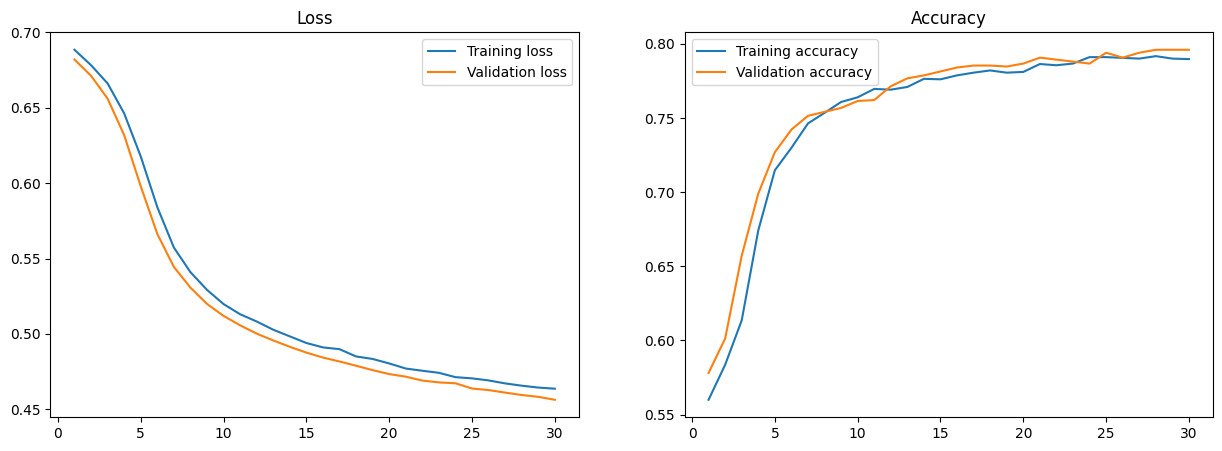

In [39]:
perform_plot(30, hist4.history)

Above plots agree with our hypothesis that the learning rate is too high, and the model reaches the optimum at early training stages. Next, a model with the same architecture of the current one but more LSTM units will be fit to try achieving a better performance.

In [40]:
# Model 5: increase number of LSTM units
model5= Sequential()
model5.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model5.add(LSTM(200, return_sequences = True))
model5.add(Dropout(0.2))
model5.add(LSTM(200, return_sequences = True))
model5.add(Dropout(0.2))
model5.add(LSTM(200))
model5.add(Dropout(0.2))
model5.add(Dense(1, activation = 'sigmoid'))

adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model5.compile(optimizer = adam_opt, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [41]:
hist5 = model5.fit(X_train_seq_padded, y_train, epochs = 30, validation_data = (X_val_seq_padded, y_val))

Epoch 1/30
188/188 [==============================] - 9s 23ms/step - loss: 0.6719 - accuracy: 0.6361 - val_loss: 0.6400 - val_accuracy: 0.7010
Epoch 2/30
188/188 [==============================] - 3s 17ms/step - loss: 0.5882 - accuracy: 0.7500 - val_loss: 0.5212 - val_accuracy: 0.7734
Epoch 3/30
188/188 [==============================] - 3s 17ms/step - loss: 0.5163 - accuracy: 0.7696 - val_loss: 0.4885 - val_accuracy: 0.7794
Epoch 4/30
188/188 [==============================] - 3s 17ms/step - loss: 0.4988 - accuracy: 0.7733 - val_loss: 0.4770 - val_accuracy: 0.7874
Epoch 5/30
188/188 [==============================] - 3s 17ms/step - loss: 0.4888 - accuracy: 0.7814 - val_loss: 0.4694 - val_accuracy: 0.7927
Epoch 6/30
188/188 [==============================] - 3s 17ms/step - loss: 0.4811 - accuracy: 0.7834 - val_loss: 0.4638 - val_accuracy: 0.7947
Epoch 7/30
188/188 [==============================] - 3s 17ms/step - loss: 0.4754 - accuracy: 0.7867 - val_loss: 0.4585 - val_accuracy: 0.7980

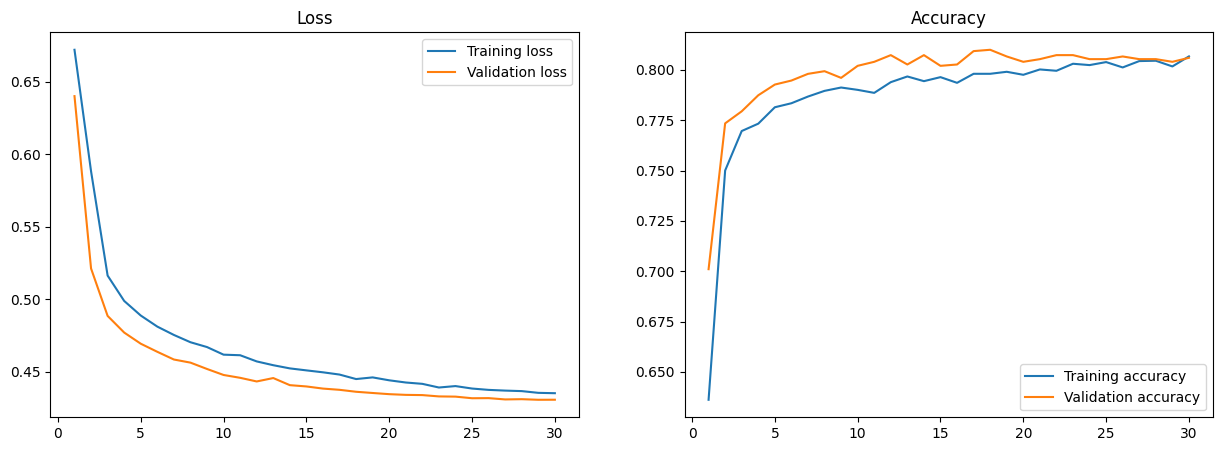

In [42]:
perform_plot(30, hist5.history)

The model achieves a better performance by increasing the number of units in each LSTM layer. Now, a different recurrent neural network - Gated Recurrent Unit (GRU) will replace the LSTM units in the current model and their performance will be compared against each other.

In [43]:
# Model 6 - explore GRU
model6 = Sequential()
model6.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
model6.add(GRU(200, return_sequences = True))
model6.add(Dropout(0.2))
model6.add(GRU(200, return_sequences = True))
model6.add(Dropout(0.2))
model6.add(GRU(200))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation = 'sigmoid'))

adam_opt = tf.keras.optimizers.Adam(learning_rate = 0.00001)
model6.compile(optimizer = adam_opt, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [44]:
hist6 = model6.fit(X_train_seq_padded, y_train, epochs = 30, validation_data = (X_val_seq_padded, y_val))

Epoch 1/30
188/188 [==============================] - 8s 21ms/step - loss: 0.6763 - accuracy: 0.5657 - val_loss: 0.6506 - val_accuracy: 0.6439
Epoch 2/30
188/188 [==============================] - 3s 16ms/step - loss: 0.6405 - accuracy: 0.6546 - val_loss: 0.6173 - val_accuracy: 0.6811
Epoch 3/30
188/188 [==============================] - 3s 16ms/step - loss: 0.6072 - accuracy: 0.6872 - val_loss: 0.5742 - val_accuracy: 0.7316
Epoch 4/30
188/188 [==============================] - 3s 16ms/step - loss: 0.5651 - accuracy: 0.7332 - val_loss: 0.5255 - val_accuracy: 0.7661
Epoch 5/30
188/188 [==============================] - 3s 16ms/step - loss: 0.5255 - accuracy: 0.7528 - val_loss: 0.4949 - val_accuracy: 0.7734
Epoch 6/30
188/188 [==============================] - 3s 16ms/step - loss: 0.5058 - accuracy: 0.7666 - val_loss: 0.4788 - val_accuracy: 0.7821
Epoch 7/30
188/188 [==============================] - 3s 16ms/step - loss: 0.4890 - accuracy: 0.7776 - val_loss: 0.4657 - val_accuracy: 0.7847

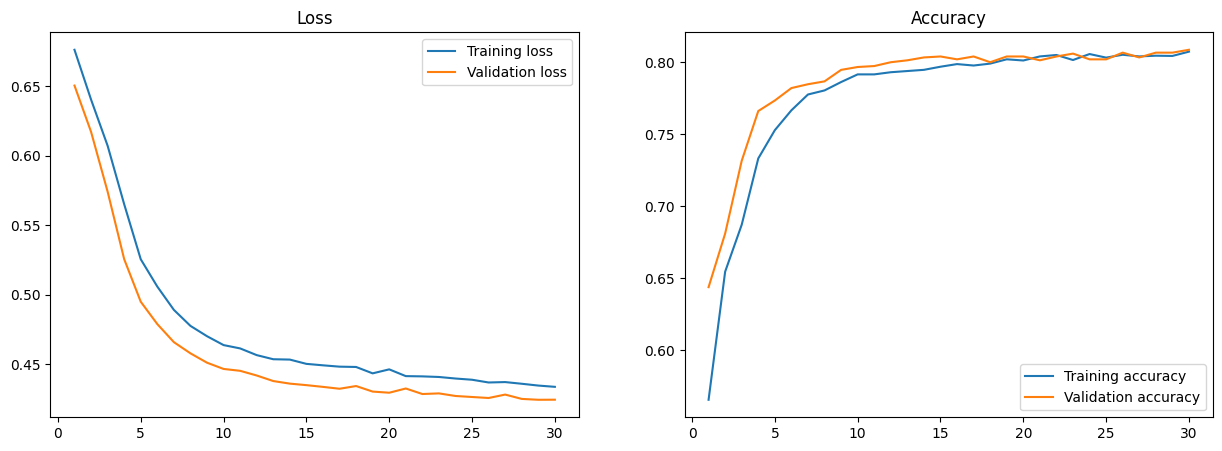

In [45]:
perform_plot(30, hist6.history)

In theory, the performance of GRU is on par with their LSTM counterparts but computationally more efficient since GRU unit has less gates. Above performance plots illustrate that the performance of GRU is comparable to LSTM but the training time is also close. One potential reason is that our problem is not challenging enough; thus, the resource required is not large enough to distinguish the differences on computational efficiency.


In the next step, hyperparameter tuning will be performed to select the optimized RNN. Random search technique will be used for searching over a pre-defined set of the following hyperparameters: number of neurons in each LSTM layer, learning rate. Model performance is evaluated with validation accuracy.

In [47]:
# Hyperparameter Tuning
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [51]:
import keras_tuner

In [56]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Embedding(input_dim = len(word_index) + 1, output_dim = max_len, weights = [embeddings_matrix], input_length = max_len, trainable = False))
    model.add(LSTM(hp.Choice('units', [60, 150, 200]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(hp.Choice('units', [60, 150, 200]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(hp.Choice('units', [60, 150, 200])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    learning_rate = hp.Float('lr', min_value = 1e-5, max_value = 1e-3, sampling = 'log')
    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = adam, loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

    return model

build_model(keras_tuner.HyperParameters())

In [63]:
rs_tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    executions_per_trial = 3,
    overwrite = True,
    directory = local_path,
    project_name = 'hp_tune'
)

rs_tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Choice)
{'default': 60, 'conditions': [], 'values': [60, 150, 200], 'ordered': True}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [65]:
rs_tuner.search(X_train_seq_padded, y_train, epochs = 15, validation_data = (X_val_seq_padded, y_val))

Trial 10 Complete [00h 02m 17s]
val_accuracy: 0.8093023300170898

Best val_accuracy So Far: 0.8230343262354533
Total elapsed time: 00h 26m 14s


In [133]:
# hyperparameter tuning summary
hp_summary = []
for i in range(10):
    hp_dict = rs_tuner.get_best_hyperparameters(10)[i].values
    hp_dict['loss'] = round(float(str(rs_tuner.oracle.trials[str(0) + str(i)].metrics.get_history('loss'))[26:33]), 44)
    hp_dict['accuracy'] = round(float(str(rs_tuner.oracle.trials[str(0) + str(i)].metrics.get_history('accuracy'))[26:33]), 4)
    hp_dict['val_loss'] = round(float(str(rs_tuner.oracle.trials[str(0) + str(i)].metrics.get_history('val_loss'))[26:33]), 4)
    hp_dict['val_accuracy'] = round(float(str(rs_tuner.oracle.trials[str(0) + str(i)].metrics.get_history('val_accuracy'))[26:33]), 4)
    hp_summary.append(hp_dict)
hp_summary_df = pd.DataFrame.from_dict(hp_summary, orient = 'columns')
hp_summary_df.rename(columns = {'units': 'Units', 'lr': 'Learning Rate', 'loss': 'Training Loss', 'accuracy': 'Training Accuracy', 'val_loss': 'Validation Loss', 'val_accuracy': 'Validation Accuracy'}, inplace = True)
hp_summary_df

,Units,Learning Rate,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy
0,200,0.000794,0.45603,0.7931,0.4437,0.8033
1,60,0.000757,0.44194,0.7994,0.4329,0.8051
2,200,0.000683,0.40842,0.8232,0.4202,0.8182
3,60,0.000127,0.41088,0.8227,0.4254,0.8133
4,60,0.000056,0.43456,0.8063,0.4268,0.8080
5,60,0.000064,0.39034,0.8328,0.4240,0.8230
6,150,0.000057,0.38857,0.8325,0.4171,0.8202
7,150,0.000025,0.43220,0.8060,0.4294,0.8080
8,150,0.000015,0.45390,0.7937,0.4426,0.8026
9,200,0.000013,0.44150,0.8009,0.4330,0.8093


The optimized model achieved through the hyparameter tuning process has a validation accuracy around 0.82, which is higher than any of earlier trained models. Each LSTM layer has 60 units and the learning rate is 0.000064. This model will be further evaluated with the test set.

In [73]:
# prediction
warnings.filterwarnings('ignore')
model_opt = rs_tuner.get_best_models(num_models = 1)[0]
X_test_seq_padded = word_processing(tweets_test_c['text'], max_len = max_len)
pred_df = tweets_test_c.drop(['text'], axis = 1)
rnn_pred = model_opt.predict(X_test_seq_padded)
pred_df['target'] = (rnn_pred >= 0.5).astype(int)
pred_df.to_csv(os.path.join(local_path, 'rnn_pred.csv'), index = False)
pred_df.head()

Before padding example1: [34, 1033, 6, 2604, 143, 88] 
Before padding example2: [449, 57, 305, 12, 1234, 2059, 600, 1945, 217] 
After padding example1: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   34 1033    6 2604
  143   88] 
After padding example2: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


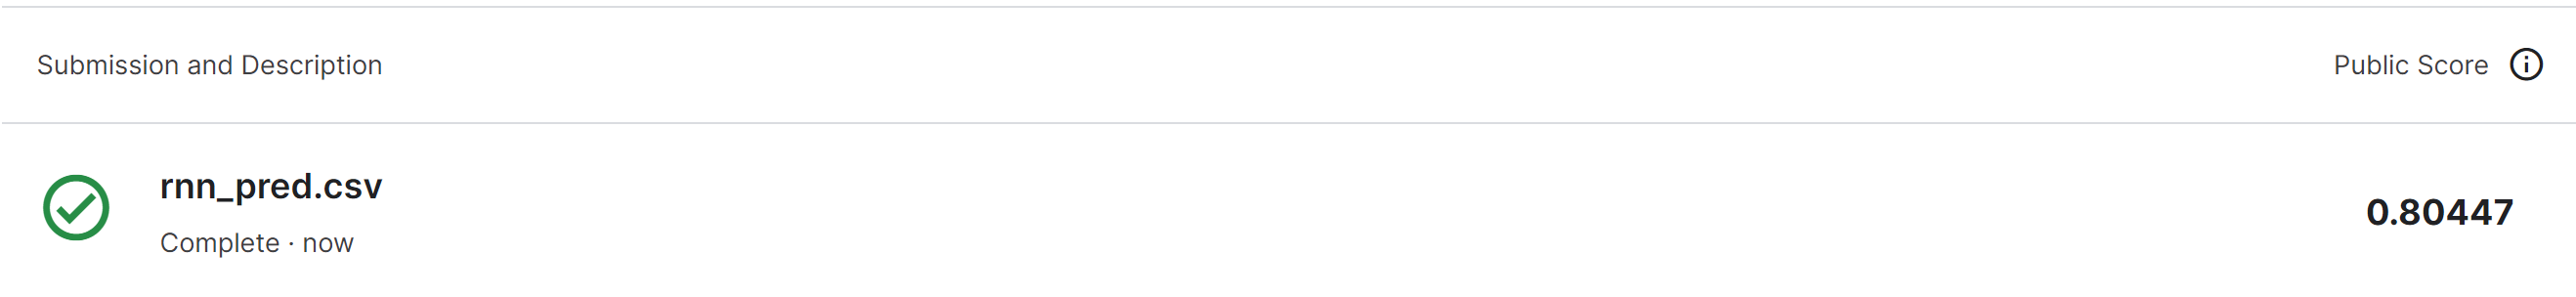

The optimized model has a F1 score evaluated on test set around 0.8, which shows the model has a decent performance.

## Discussion

In this study, the application of recurrent neural network on text classification is explored through the comparison on performance of various neural network architecture. The optimized model is select through tuning hyperparameters including learning rate and number of LSTM units in each LSTM layer. During the learning process, dropout layers are found to be useful for reducing overfitting and a deeper neural network achieves a better performance score. It should also be kept in mind that a model with more than enough layers tends to overfit on the training data. An interesting phenomenon observed during the training process is that the validation loss fluctuates around a loss value. This issue is handled by adjusting learning rate to a lower value, which means the old model either passed or reached the optimum in earlier training process. Furthermore, both performance and computation efficiency are comparable between LSTM and GRU. A potential reason is that our problem is not complex enough to distinguish the gaps. Although the RNN is optimized through a performance-based iterative process and hyperparameter tuning, there is still room for improvement. Different word embedding algorithm can be applied to select the one that works the best with our text data. The recurrent neural network can also grow deeper to optimize the performance score. Theoretically, a deeper neural network performs better as long as we stop adding more layers before overfitting.